# Modello esponenziale {#sec-stan-exponential-model}

**Prerequisiti**

- Leggere il @sec-cont-rv-distr.

**Concetti e competenze chiave**

- Comprensione del modello gamma-esponenziale e dei suoi parametri.
- Utilizzo di Stan per ottenere campioni a posteriori dai modelli statistici.
- Capacità di incorporare covariate nei modelli per esplorare relazioni complesse.
- Vantaggi del campionamento bayesiano rispetto ai metodi tradizionali per l'analisi dei dati.

**Preparazione del Notebook**

In [1]:
import logging
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

In [2]:
seed: int = sum(map(ord, "stan_exponential_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduction {.unnumbered}

Nel @sec-gamma-exponential-model abbiamo discusso il modello gamma-esponenziale, illustrando come i parametri possano essere stimati sia attraverso un approccio basato su una griglia di valori sia con una procedura analitica. In questo capitolo, approfondiremo l'argomento utilizzando Stan per ottenere campioni a posteriori del modello gamma-esponenziale.

L'utilizzo di Stan offre vantaggi notevoli rispetto ai metodi precedentemente discussi. In particolare, oltre alla stima dei parametri tramite campionamento bayesiano, Stan permette di esaminare l'effetto di variabili aggiuntive, o covariate, sui parametri del modello. Questa flessibilità nell'incorporare covariate non è possibile con i metodi grid-based o analitici, rendendo Stan uno strumento potente per l'estensione e l'arricchimento dei modelli statistici.

## Modellare i Tempi di Reazione

Prendendo ispirazione dal [tutorial](https://betanalpha.github.io/assets/chapters_html/racing.html) di Michael Betancourt, affrontiamo il problema di costruire un modello bayesiano per descrivere i tempi di reazione dei soggetti nello svolgimento di un compito psicologico. Lo scopo del tutorial è mostrare come i parametri della distribuzione esponenziale stimati dal modello possano dipendere da altre variabili che influenzano le osservazioni.

In questo tutorial, immagineremo di avere tre informazioni per ciascun soggetto:

1. *Tempo di reazione*: Il tempo necessario a completare il compito.
2. *Difficoltà del compito*: I soggetti svolgono compiti con diversi livelli di difficoltà.
3. *Abilità pregressa*: Una misura dell'abilità dei soggetti che è stata registrata prima del compito.

### Obiettivo

Il nostro obiettivo è costruire un modello che, passo dopo passo, diventi sempre più complesso. Inizieremo con un modello semplice per un singolo soggetto, senza considerare covariate. Successivamente, espanderemo il modello per includere più soggetti e infine aggiungeremo le covariate (difficoltà del compito e abilità) per studiare come queste influenzano i tempi di reazione.

### Struttura del Tutorial

1. **Modello 1**: Adattiamo un modello esponenziale semplice ai dati di un singolo soggetto con più osservazioni. In questo modello non consideriamo altre variabili.
2. **Modello 2**: Estendiamo il modello a più soggetti, con una singola osservazione per ciascun soggetto. Questo è un modello gerarchico bayesiano semplice, senza covariate.
3. **Modello 3**: Aggiungiamo le covariate (difficoltà del compito e abilità del soggetto) al modello gerarchico, modellando come queste informazioni influenzano il parametro $\lambda$ della distribuzione esponenziale.

## Modello 1: Modello Esponenziale per un Singolo Soggetto

Nel primo modello consideriamo un singolo soggetto e modelliamo i tempi di reazione come estratti da una distribuzione esponenziale, che descrive eventi che avvengono a una certa velocità costante. Il parametro $\lambda$ della distribuzione esponenziale rappresenta il tasso con cui avvengono gli eventi (in questo caso, quanto velocemente il soggetto risponde).

### Implementazione del Modello in Stan

In [10]:
stan_file = os.path.join(project_directory, "stan", "betancourt_model_1.stan")
model = CmdStanModel(stan_file=stan_file)

In [11]:
print(model.code())

data {
  int<lower=0> N; // Numero di osservazioni (tempi di reazione) per il soggetto
  array[N] real<lower=0> reaction_times; // Tempi di reazione osservati
}
parameters {
  real<lower=0> lambda; // Parametro lambda della distribuzione esponenziale (tasso)
}
model {
  // Prior debolmente informativo su lambda
  lambda ~ normal(1, 1);
  
  // Likelihood: distribuzione esponenziale per i tempi di reazione
  reaction_times ~ exponential(lambda);
}



### Spiegazione del Modello

- **Dati**: Il numero di osservazioni $N$ rappresenta il numero di tempi di reazione raccolti per il singolo soggetto. La variabile `reaction_times` è un array di dimensione $N$ che contiene i tempi di reazione osservati.
- **Parametro**: Il parametro $\lambda$ è il tasso della distribuzione esponenziale, che rappresenta quanto velocemente il soggetto risponde.
- **Prior**: Il prior su $\lambda$ è una distribuzione normale con media 1 e deviazione standard 1, che rappresenta una conoscenza a priori debolmente informativa su quanto ci aspettiamo che il tasso di reazione sia vicino a 1.
- **Likelihood**: I tempi di reazione sono modellati come estratti da una distribuzione esponenziale con parametro $\lambda$.

Utilizziamo dei dati simulati.

In [12]:
stan_data = {
    "N": 10, 
    "reaction_times": [0.3, 0.5, 0.7, 0.4, 0.6, 0.8, 0.2, 0.9, 0.3, 0.5]
}
print(stan_data)

{'N': 10, 'reaction_times': [0.3, 0.5, 0.7, 0.4, 0.6, 0.8, 0.2, 0.9, 0.3, 0.5]}


Eseguiamo il campionamento.

In [13]:
fit_1 = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori del parametro `lambda`.

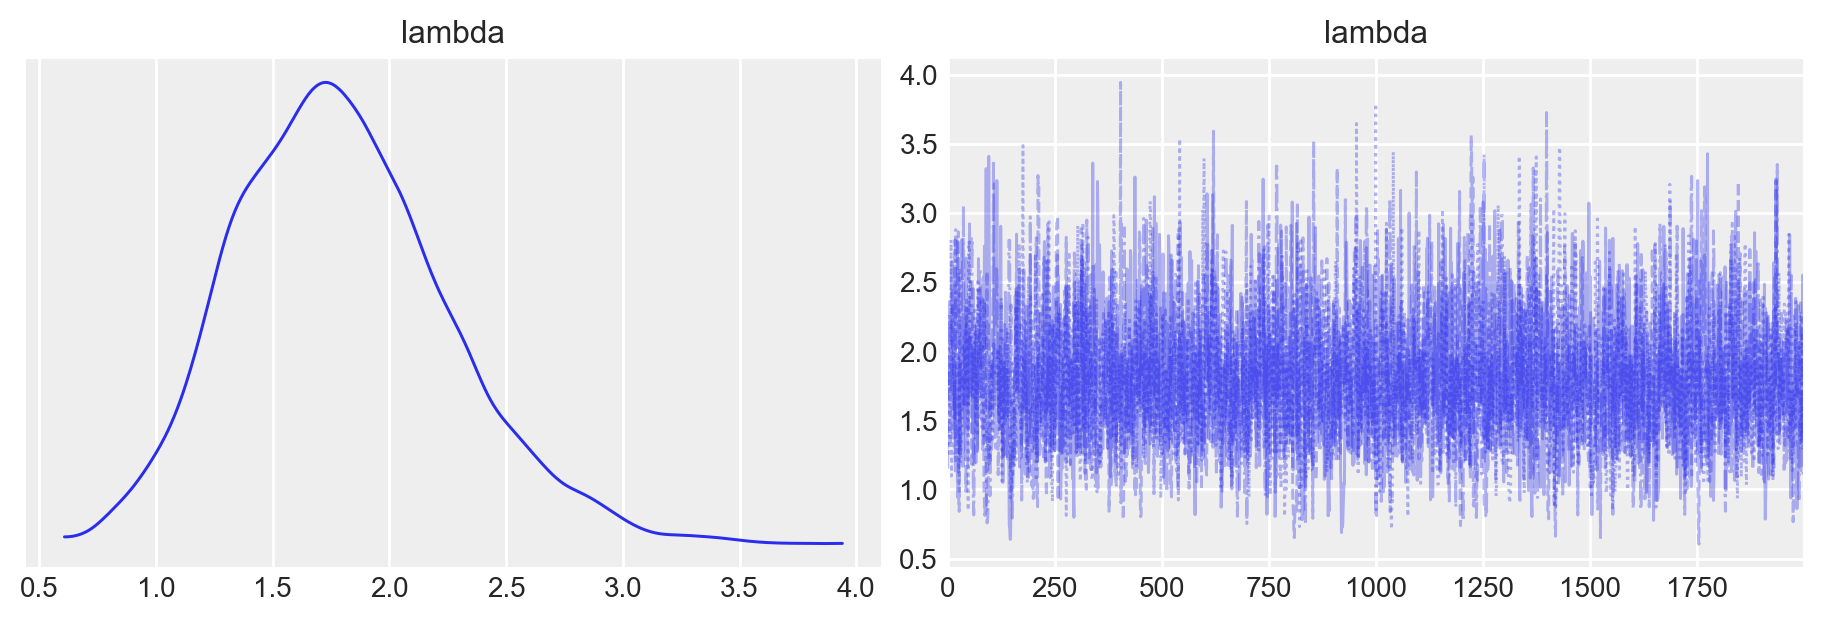

In [14]:
az.plot_trace(fit_1, combined=True, figsize=(9, 3))
plt.show()

Generiamo un sommario numerico della distribuzione a posteriori.

In [15]:
az.summary(fit_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,1.795,0.46,0.946,2.662,0.009,0.006,2573.0,2709.0,1.0


## Modello 2: Modello Gerarchico per Più Soggetti

Nel secondo passo, estendiamo il modello a un campione di più soggetti, ciascuno con un singolo tempo di reazione osservato. Questo modello introduce la gerarchia: assumiamo che ciascun soggetto abbia un proprio parametro $\lambda$, ma che tutti i $\lambda$ individuali siano distribuiti intorno a un parametro globale $\lambda_{\text{global}}$.

### Implementazione del Modello in Stan

In [16]:
stan_file = os.path.join(project_directory, "stan", "betancourt_model_2.stan")
model = CmdStanModel(stan_file=stan_file)

In [17]:
print(model.code())

data {
  int<lower=1> N_subjects; // Numero di soggetti
  array[N_subjects] real<lower=0> reaction_times; // Tempi di reazione osservati per ciascun soggetto
}
parameters {
  real<lower=0> lambda_global; // Parametro globale lambda
  real<lower=0> sigma_lambda; // Deviazione standard delle differenze individuali
  array[N_subjects] real<lower=0> lambda_individual; // Parametri lambda individuali per ciascun soggetto
}
model {
  // Prior su lambda_global e sigma_lambda
  lambda_global ~ normal(1, 1);
  sigma_lambda ~ normal(0, 1);
  
  // I lambda individuali sono distribuiti attorno a lambda_global
  lambda_individual ~ normal(lambda_global, sigma_lambda);
  
  // Likelihood: distribuzione esponenziale per i tempi di reazione
  reaction_times ~ exponential(lambda_individual);
}



### Spiegazione del Modello

- **Dati**: Il numero di soggetti $N_{\text{subjects}}$ e i tempi di reazione per ciascun soggetto.
- **Parametri**:
  - $\lambda_{\text{global}}$ rappresenta il tasso globale per il campione di soggetti.
  - $\sigma_{\lambda}$ descrive la variabilità tra i parametri $\lambda$ individuali.
  - I parametri $\lambda_{\text{individual}}$ sono i tassi individuali per ciascun soggetto.
- **Likelihood**: I tempi di reazione di ciascun soggetto sono modellati come distribuzioni esponenziali con i parametri $\lambda_{\text{individual}}$.

Creaiamo un campione di dati simulati.

In [18]:
stan_data = {
    "N_subjects": 15,
    "reaction_times": [0.5, 0.6, 0.7, 1.4, 0.6, 1.8, 1.2, 0.9, 1.3, 0.5, 1.1, 0.3, 0.4, 0.1, 0.2],
}
print(stan_data)

{'N_subjects': 15, 'reaction_times': [0.5, 0.6, 0.7, 1.4, 0.6, 1.8, 1.2, 0.9, 1.3, 0.5, 1.1, 0.3, 0.4, 0.1, 0.2]}


Eseguiamo il campionamento.

In [19]:
fit_2 = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori.

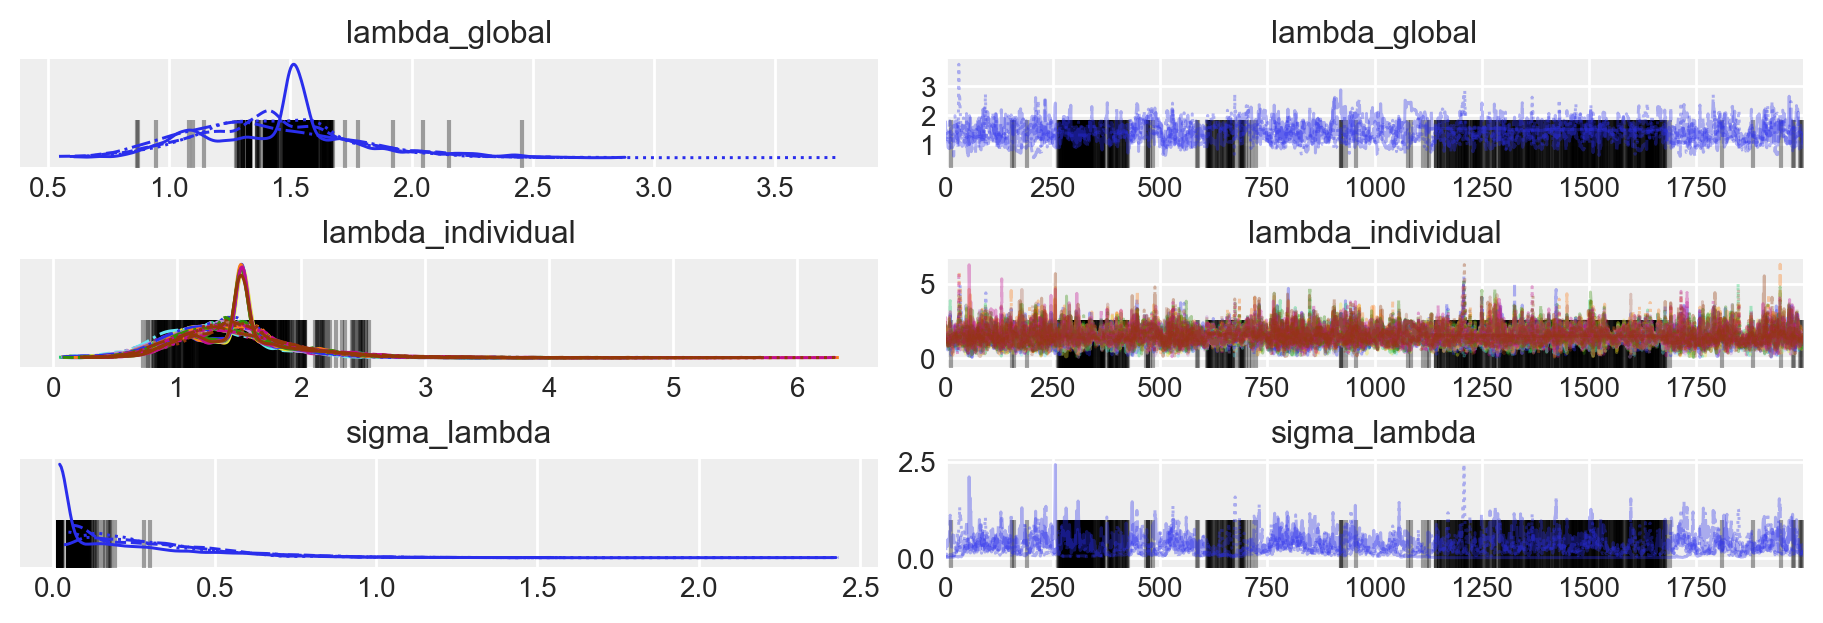

In [20]:
az.plot_trace(fit_2, figsize=(9, 3))
plt.show()

In [21]:
az.summary(fit_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_global,1.427,0.325,0.807,2.025,0.014,0.010,458.0,1032.0,1.01
lambda_individual[0],1.453,0.463,0.605,2.314,0.014,0.010,949.0,1881.0,1.02
lambda_individual[1],1.446,0.462,0.624,2.366,0.014,0.010,887.0,1901.0,1.02
lambda_individual[2],1.435,0.449,0.646,2.345,0.015,0.011,718.0,2058.0,1.02
lambda_individual[3],1.367,0.423,0.614,2.204,0.016,0.011,617.0,1464.0,1.01
lambda_individual[4],1.449,0.464,0.656,2.355,0.014,0.010,921.0,1954.0,1.02
lambda_individual[5],1.322,0.414,0.486,2.093,0.016,0.012,584.0,1490.0,1.01
lambda_individual[6],1.386,0.437,0.581,2.232,0.015,0.010,769.0,1684.0,1.01
lambda_individual[7],1.421,0.448,0.564,2.265,0.014,0.010,851.0,2034.0,1.02
lambda_individual[8],1.371,0.431,0.559,2.210,0.015,0.011,674.0,1685.0,1.01


## Modello 3: Modello Completo con Difficoltà del Compito e Abilità

Nel terzo passo, introduciamo le covariate: la difficoltà del compito e l'abilità del soggetto. Queste informazioni aggiuntive influenzano i tempi di reazione modellando il parametro $\lambda_{\text{individual}}$ come una funzione della difficoltà del compito e dell'abilità del soggetto.

### Implementazione del Modello in Stan

In [99]:
stan_file = os.path.join(project_directory, "stan", "betancourt_model_3.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N_subjects;        // Numero di soggetti
  array[N_subjects] real<lower=0> reaction_times; // Tempi di reazione per ciascun soggetto
  array[N_subjects] real<lower=0> task_difficulty; // Difficoltà del compito per ciascun soggetto
  array[N_subjects] real ability;                 // Abilità individuale per ciascun soggetto
}

parameters {
  real<lower=0> lambda_global;    // Parametro globale lambda
  real<lower=0> beta_difficulty;  // Effetto della difficoltà del compito
}

transformed parameters {
  array[N_subjects] real<lower=0> lambda_individual; // Parametri lambda individuali

  // Il parametro lambda individuale dipende dalla difficoltà del compito e dall'abilità
  for (i in 1:N_subjects) {
    lambda_individual[i] = lambda_global + beta_difficulty * task_difficulty[i] - ability[i];
  }
}

model {
  // Priori
  lambda_global ~ normal(1, 1);
  beta_difficulty ~ normal(0, 1);

  // Likelihood
  reaction_times ~ exponential(lambda_individual);
}



### Spiegazione del Modello

- **Dati**: In questo modello, oltre ai tempi di reazione osservati per ciascun soggetto, includiamo due variabili aggiuntive come covariate:
  - **Difficoltà del compito**: Ogni soggetto svolge un compito con un livello di difficoltà diverso, rappresentato dalla variabile `task_difficulty`.
  - **Abilità individuale**: Misura delle capacità preesistenti di ciascun soggetto, rappresentata dalla variabile `ability`.

- **Parametri**: 

  - Il parametro $\lambda_{\text{individual}}$ rappresenta il tasso della distribuzione esponenziale per ciascun soggetto e riflette la velocità con cui il soggetto completa il compito. 
  - Questo parametro dipende sia dal **tasso globale** $\lambda_{\text{global}}$, che rappresenta la media del tasso di completamento dei compiti nel campione, sia dalle due covariate:
  
    - **Difficoltà del compito** (`beta_difficulty * task_difficulty`): Compiti più difficili tendono a ridurre il valore di $\lambda_{\text{individual}}$, rendendo i tempi di reazione più lunghi.
    - **Abilità del soggetto** ($- \text{ability}[i]$): Soggetti con maggiore abilità tendono ad avere tempi di reazione più rapidi, quindi valori più alti di abilità diminuiscono i tempi di reazione.

  La relazione tra queste variabili è specificata nella formula:

  ```stan
    for (i in 1:N_subjects) {
        lambda_individual[i] = lambda_global + beta_difficulty * task_difficulty[i] - ability[i];
  }
  ```

  Questo significa che per ciascun soggetto $i$, il tasso esponenziale individuale $\lambda_{\text{individual}}[i]$ è calcolato come una somma lineare di un effetto globale ($\lambda_{\text{global}}$), un effetto legato alla difficoltà del compito e un effetto legato all'abilità individuale.

- **Likelihood**: La distribuzione esponenziale viene utilizzata per modellare i tempi di reazione. La verosimiglianza è specificata come:

  ```stan
  reaction_times ~ exponential(lambda_individual);
  ```

  In questa specificazione, i tempi di reazione sono modellati come variabili esponenziali con parametro $\lambda_{\text{individual}}$. Poiché $\lambda_{\text{individual}}$ è un vettore che varia tra i soggetti, ciascun soggetto ha il proprio valore di $\lambda$, che riflette la sua reattività in base alla difficoltà del compito e alla sua abilità.

La distribuzione esponenziale è particolarmente adatta a modellare tempi di attesa o di reazione, perché si concentra su eventi che si verificano a un tasso costante nel tempo. In questo modello, il parametro $\lambda_{\text{individual}}$, che controlla il tasso di completamento del compito, varia per ciascun soggetto in funzione della difficoltà del compito e dell'abilità. Questo permette al modello di adattarsi in modo flessibile ai dati, considerando sia le caratteristiche del compito che le differenze individuali tra i soggetti.

Simuliamo un campione di dati.

In [100]:
# Parameters for data simulation
np.random.seed(42)
N_subjects = 15

# Global parameters
lambda_global = np.random.normal(1, 1)
beta_difficulty = np.random.normal(0, 1)

# Simulate task difficulty and individual ability
task_difficulty = np.random.uniform(0, 2, N_subjects).tolist()  # Ensuring it is a list
ability = np.random.normal(0, 1, N_subjects).tolist()  # Ensuring it is a list

# Compute individual lambdas
lambda_individual = (
    lambda_global + beta_difficulty * np.array(task_difficulty) - np.array(ability)
)
lambda_individual = np.clip(lambda_individual, 0.01, None)

# Simulate reaction times based on the exponential distribution
reaction_times = np.random.exponential(
    1 / lambda_individual
).tolist()  # Ensuring it is a list

# Organize the data into a dictionary
simulated_data = {
    "N_subjects": N_subjects,
    "reaction_times": reaction_times,
    "task_difficulty": task_difficulty,  # Make sure this is a list/array, not a scalar
    "ability": ability,  # Make sure this is a list/array, not a scalar
}

# Make sure that you pass the data to Stan in the correct structure
simulated_data

{'N_subjects': 15,
 'reaction_times': [0.026306979473107298,
  3.0271953252826425,
  0.9104813464865819,
  0.04371260437678165,
  0.358122171029951,
  0.01750037382415924,
  1.1802461283350816,
  0.087038206386994,
  0.512264739534741,
  0.59219237344445,
  73.41108959092286,
  0.7580490737777282,
  0.154346968693783,
  1.7807423128002173,
  0.7413644923062442],
 'task_difficulty': [1.4639878836228102,
  1.1973169683940732,
  0.31203728088487304,
  0.3119890406724053,
  0.11616722433639892,
  1.7323522915498704,
  1.2022300234864176,
  1.416145155592091,
  0.041168988591604894,
  1.9398197043239886,
  1.6648852816008435,
  0.4246782213565523,
  0.36364993441420124,
  0.36680901970686763,
  0.6084844859190754],
 'ability': [-2.6125490126936013,
  0.9503696823969031,
  0.8164450809513273,
  -1.523875997615861,
  -0.4280460641762345,
  -0.7424068371191724,
  -0.7033438017074073,
  -2.1396206560762394,
  -0.6294749609242508,
  0.5977204669126083,
  2.5594880310377928,
  0.3942330218796011,

Eseguiamo il campionamento.

In [101]:
fit_3 = model.sample(
    data={
        "N_subjects": 15,
        "reaction_times": reaction_times,  # List of reaction times
        "task_difficulty": task_difficulty,  # List of task difficulties
        "ability": ability,  # List of individual abilities
    },
    chains=4,
    iter_sampling=2000,
    iter_warmup=1000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori.

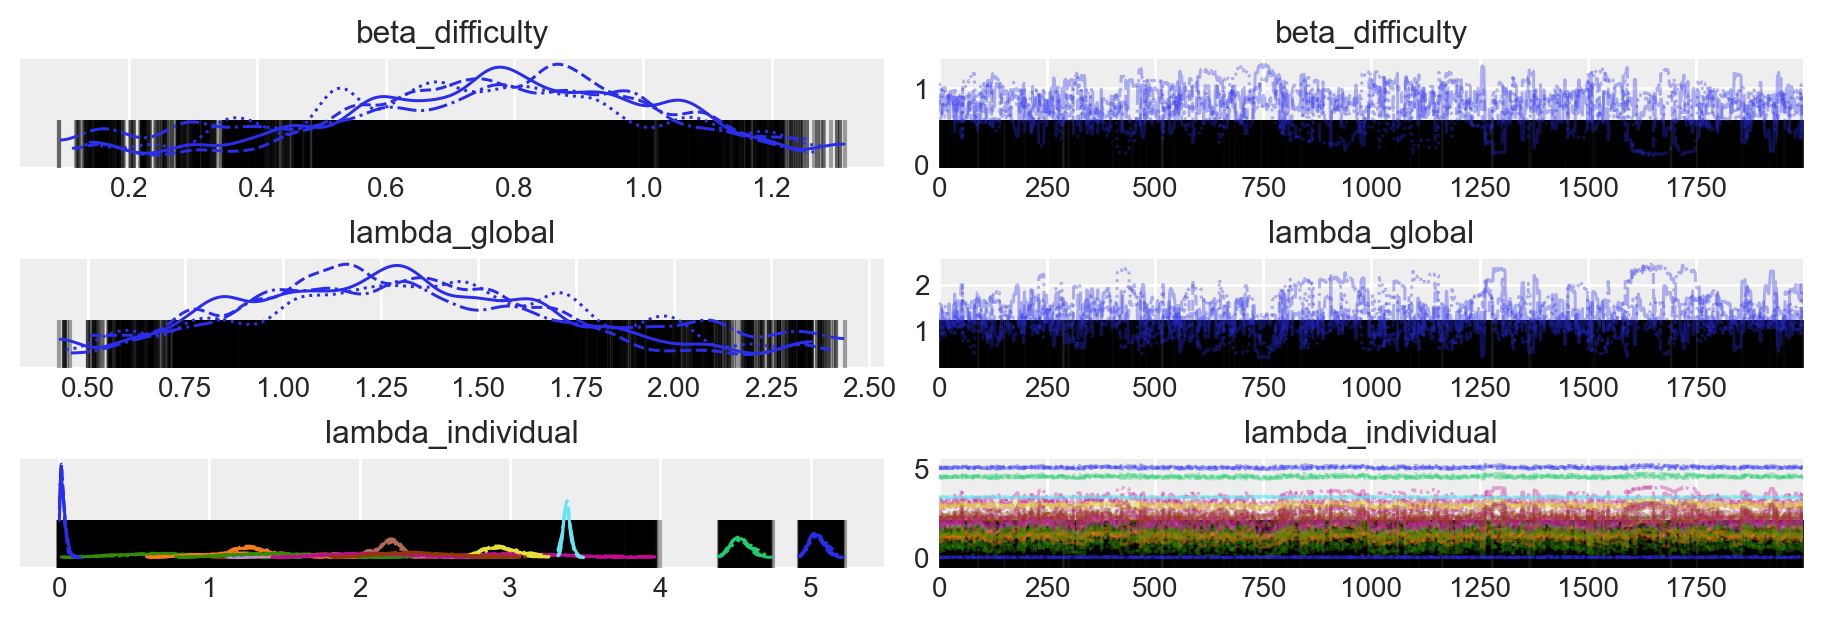

In [102]:
az.plot_trace(fit_3, figsize=(9, 3))
plt.show()

In [103]:
az.summary(fit_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_difficulty,0.753,0.252,0.276,1.210,0.017,0.012,241.0,120.0,1.01
lambda_global,1.333,0.419,0.574,2.118,0.028,0.023,241.0,121.0,1.01
lambda_individual[0],5.048,0.054,4.946,5.145,0.003,0.002,275.0,170.0,1.01
lambda_individual[1],1.284,0.119,1.062,1.502,0.008,0.006,248.0,123.0,1.01
lambda_individual[2],0.751,0.341,0.133,1.385,0.023,0.020,241.0,120.0,1.01
lambda_individual[3],3.092,0.341,2.474,3.726,0.023,0.017,241.0,120.0,1.01
lambda_individual[4],1.849,0.390,1.141,2.577,0.026,0.021,241.0,121.0,1.01
lambda_individual[5],3.380,0.026,3.329,3.429,0.001,0.001,383.0,271.0,1.01
lambda_individual[6],2.941,0.117,2.722,3.157,0.008,0.006,248.0,123.0,1.01
lambda_individual[7],4.539,0.065,4.420,4.662,0.004,0.003,263.0,148.0,1.01


## Considerazioni Conclusive

In questo capitolo, abbiamo dimostrato come l'utilizzo di Stan permetta non solo di stimare i parametri del modello gamma-esponenziale in modo efficiente, ma anche di estendere il modello per includere covariate che influenzano i parametri stessi. Questa capacità di esplorare relazioni più complesse tra le variabili rappresenta un significativo passo avanti rispetto ai metodi più tradizionali, come le stime analitiche o basate su griglia. L'integrazione di Stan nei processi di modellazione consente un approccio più flessibile e potente per la comprensione dei dati e delle dinamiche sottostanti.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [104]:
%load_ext watermark
%watermark -n -u -v -iv -m 

Last updated: Wed Sep 11 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
matplotlib: 3.9.1
numpy     : 1.26.4
arviz     : 0.18.0
logging   : 0.5.1.2
cmdstanpy : 1.2.4
scipy     : 1.14.0
pandas    : 2.2.2

